<a href="https://colab.research.google.com/github/musicjae/NLP/blob/master/NPLM(2003).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving n4.png to n4.png
User uploaded file "n4.png" with length 160758 bytes


In [ ]:
from IPython.display import Image

# 1. INTRO  

&nbsp;&nbsp;&nbsp;&nbsp;확률적 언어 모델NPLM(Neural Probabilistic Language Model)은 이전 word sequences를 통해 다음 word sequences를 예측하는 것이다. (이것은 최근들어 'NNLM' (Neural Networks Language Models)라고 불리기도 한다.)


## 1.1 도입 동기  
  
 === 언어 모델링을 어렵게 만드는 문제: **차원의 저주**  ===
  
 언어 모델링에서, #(Input words)가 증가하면,  #(Param)은 기하급수적으로 커진다. 이 곤경은 기존의 **원-핫 인코딩** 방법에서 자주 나타난다.  


### 1.1.1 원핫 인코딩  
  
&nbsp;&nbsp;&nbsp;&nbsp;일종의 Discrete representation(혹은 Localist representation)인 원핫 인코딩은 각 단어에 인덱스를 부여하는 희소 벡터를 할당하는 방법이다. 단어 words 집합(vocabulary) --- which is 서로 다른 단어들의 집합 --- 안에 아래 같이 3 개의 words가 있다고 해보자.  

사과: [1 0 0]  
배: [0 1 0]  
복숭아: [0 0 1]  

In [ ]:
# For 1.1.1

import numpy as np

words = ['사과','배','복숭아']
onehot_vectors = []

for i in range(len(words)):

    onehot_vectors.append(i)


for i in range(len(onehot_vectors)):

    print( (words[i], np.eye(len(onehot_vectors))[i]))

('사과', array([1., 0., 0.]))
('배', array([0., 1., 0.]))
('복숭아', array([0., 0., 1.]))


### 1.1.2 원핫 인코딩이 가진 곤경  
  
(1) 원핫 인코딩에서, Input words의 수가 크게 늘어난다면, 가령 그 수가 1 만개라면, 각각의 단어 벡터들은 희소 벡터 형태를 가진 1 만 차원의 벡터가 되는데, 이것은 메모리 효율과 계산 복잡도 차원에서 비효율적이다.  우리는 Input words의 개수가 늘어나더라도 더 효율적으로 이 words를 처리할 필요가 있다.
  
(2) 원핫 인코딩의 경우에, 단어들의 유사성을 비교하기 어렵다. 위 사례에서 보듯이, 두 개의 단어 벡터들 간의 dot product는 항상 0 이기 때문이다. 이 사실은 두 벡터 간의 cosine 관계가 직교 orthogonal 하다는 것을 의미하고, 이는 두 원핫 벡터가 서로 연관이 없다는 것을 함의한다. 하지만 이것은 문제적이다. 왜냐하면 각 벡터와 연결된 단어들 간의 상관성이 있을 수 있기 때문이다. 우리는 단어 '강아지'와 '고양이'가 서로 금수라는 측면에서 유사하다고 간주할 수 있고, 단어 '낙관적인'과 '비관적인'은 서로 반의어 관계에 있다는 것을 받아들일 수 있다.

In [ ]:
# For 1.1.2.(2)
a = [1, 0,0]
b=[0,1,0]
result = 0

for i in range(3):

    result += a[i]*b[i]

print(result)

0


## 1.2 분산 표현 Distributed Representations  
  
본고에서는 분산 표현을 통해 언어 모델링을 하고자 한다. 즉, 이것은 분산 표현을 통해 이전 단어 시퀀스를 가지고 다음에 나올 단어 시퀀스를 예측하고자 한다. 여기서 분산 표현을 사용하는 이유는 이것을 도입하면 기존의 언어 모델링 때 나타나는 차원의 저주가 다소 해소되고, 뿐만 아니라 단어들 간의 유사성 비교도 가능해지기 때문이다.  
분산 표현 distributed representations은 -- 원핫 인코딩 경우와 같이 단어와 벡터 간의 one to one 관계가 아닌 -- 이들 간의 many to many 관계에 의해 표현된다. 즉, 분산 표현에서는 어떤 단일의 concept(word)의 표현이라도 여러 processing units에 대해 분포된다. 대개 이 units의 벡터값은 1, 0 이 아닌 연속적인 값(실수)이다. 이것은 소위 'anti-localist'라 불리는 connectionist (McClelland, Hinton etc)에 의해 옹호되었다. 아래 그림은 분산 표현에 대한 사례를 보여준다.  


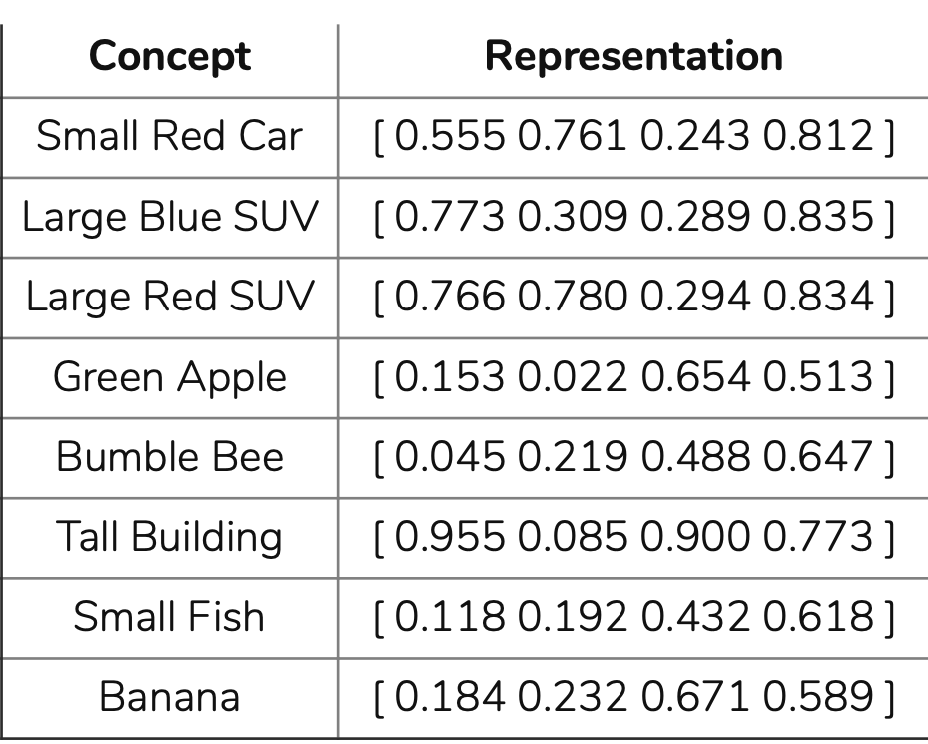

In [ ]:
Image('nnlm1.png',width=600)

이 분산 표현을 이용하면 우리는 1.1.2에서 살펴보았던 원핫 인코딩(localist 표현)이 갖는 2 가지 곤경을 모두 어느 정도 해소할 수 있다.  
  
(1') 분산 표현에서는 words가 사상된 (processing unit vectors인) **word feature vectors**을 통해 단어 시퀀스의 **결합 확률 함수 joint probability function**를 표현한다. 이것은 words와 feature vectors가 many to many 관계에 있게 만들어 준다. 이것이 차원의 저주를 해소하는 까닭은 Feature vecotors의 수가 words의 수보다 훨씬 작기 때문이다. 이 Feature vectors는 단어의 여러 측면을 표현하기 때문에 원핫 인코딩 경우처럼 words의 수에 비례한 많은 unit vector를 필요로 하지 않는다.  
  
(2') 분산 표현에서는 단어 간의 유사도를 비교할 수 있다. 원핫 인코딩에서는 가령 '곰'과 '사자'가 유사한 정도와 '사자'와 '바나나'가 유사한 정도가 같았다면, 분산 표현에서는 이제 그렇지 않다. 위의 사례 그림을 볼 때, 우리는 Red SUV와 Blue SUV의 유사성 정도는 그것들과 Small Fish 간의 유사성 정도 보다 더 크다는 것을 알 수 있다.

## 1.3 이전 작업들과의 연관  
  
학습된 시퀀스의 일반화로부터 new 시퀀스를 얻기 위한 words 간의 유사성 비교는 **새로운** **것이** **아니다.**

### 1.3.1 조건적 확률의 곱으로 표현된 신경망 사용  
  
신경망NN을 사용하는 것은 "각각의 랜덤 변수가 다양한 nature를 갖는 집합 Z1, ... Zn"의 결합 확률을 학습하는 데 유용하다는 것은 이미 잘 알려져 있다. 하지만 우리 모델에서 이 결합 확률은 **조건적**  **확률의** **곱**으로 분해된다:  
  

$\hat{P}(Z_1 = z_1, ..., Z_n = z_n) = \prod_i \hat{P}(Z_i = z_i|g_i(Z_{i-1}, Z_{i-2} = z_{i-2}, ..., Z_1 = z_1))$  
  
  

여기서 $g(.)$는, 임의의 order에서, 이전 Z의 값($Z_{i-1})$을 고려할 때 $Z_i$의 **조건적** **분포**를 표현하는 매개변수를 계산해주는 output block $g_i()$을 가진 신경망에 의해 표현된다. 

### 1.3.2 매개 변수 공유  
  
- 매개 변수 공유 across input words at different positions  
  
 == > $\forall Z_i$는 동일한 유형의 대상 --- a word ---만을 지칭한다.

### 1.3.3 연속적인 실수 벡터 사용  
  
이전 작업들에서는 대개 이산 랜덤 (또는 deterministic) 변수를 사용하여 단어들 간의 유사성을 비교하고자 했다. 하지만 우리 모델에서는 이것을 수행하기 위해 (학습된 분산 특징 벡터 같은) 연속적인 실수real 벡터를 사용한다.

# 2. 신경망 모델  
  


## 2.1 준비  
  
- 트레이닝 셋: 시퀀스 $w_1, ..., w_T$ of $w_t \in V$ where V is large but finite set.  
  
- 목표: 적당한 모델에게 높은 표본외out of sample 가능도를 부여하기 위해 $f(w_t, ..., w_{t-n+1}) = \hat{P}(w_t|w_1^{t-1})$을 학습시키는 것  

### 2.1.1  

  
위 식은 다시 $f(w_t, ..., w_{t-n+1}) = g(i, C(w_{t-1}), ..., C(w_{t-n+1}))$로 표현된다.  
  
(1) 함수 C:  
- V의 임의의 원소 $i$ $\to$ $C(i) \in R^m$. 여기서 $i$는 a word  
- 이 함수는 V 내의 각 word와 연관된 **Distributed** **feature** **vectors** 를 표현한다.  
- C는 모든 context 내의 words에 대해 공유된다. (매개변수 공유)  

- $C^{|V| x m}$인 free parameters.    
  
(2) 단어에 대한 확률 함수 g:  
  
- Context 내의 단어의 feature vector의 입력 시퀀스: $$((C(w_{t-t+1}), ..., C(w_{t-1}))$$
  
- 다음에 나올 단어 $w_t$에 대한 V 내의 words의 조건적 확률 분포:  
  $$\hat{P}(w_t = i | w_1^{t-1})$$  
    
- The function g is this: $$g: ((C(w_{t-t+1}), ..., C(w_{t-1})) \to \hat{P}(w_t = i | w_1^{t-1})$$  
  
  

(3) Thus, it follows that  $$f(w_t, ..., w_{t-n+1}) = \hat{P}(w_t|w_1^{t-1})$$

## 2.2 트레이닝  
  
위 2.1 에서의 작업들은 아래 그림과 같이 요약될 수 있다. 우리는 위에서 더 나아가 트레이닝을 통해 $\theta = (C, \omega)\ \ where\ \ \omega\ \ is\ \ parameters$인 $\theta$를 찾고자 한다. 이 $\theta$는 the training corpus penalized log-likelihood를 최대화하는 변수이다.

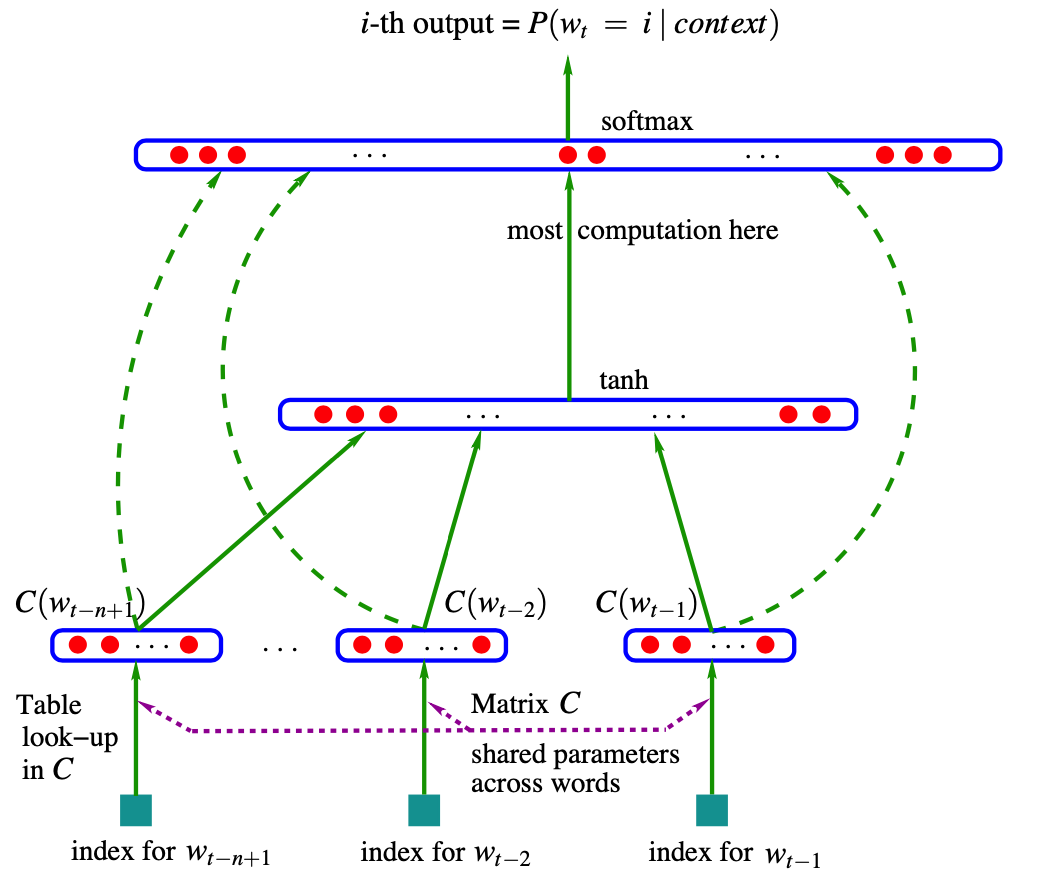

In [ ]:
Image('n2.png',width = 600)

### 2.2.1 Loss & output

- Loss:  
$$ L = \frac{1}{T} \sum_i log\ f(w_t, w_{t-1}, ..., w_{t-n+1}; \theta) + R(\theta)$$  
  
- 총합이 1인 softmax output:  

$$\hat{P}(w_t|w_{t-1}, ..., w_{t-n+1}) = \frac{e^{y_{wt}}}{\sum_i e^{y_i}}$$  
 
> 위 식에서 $y_i$는 $y=b + Wx + U\ tanh(d+Hx)$로 계산된 각 output 단어 i에 대한 unnormalized 로그 확률이다.  $(b,W, U, H)$는 매개변수.  
  


### 2.2.2 Introductory remarks  

  

* $tanh$ 는 원소 by 원소로 적용된다  
* $W$는 선택적으로 0  
* $x$는 행렬 C로부터 input word features의 연결이다:  
$$x = (C(w_{t-1}), ..., C(w_{t-n+1}))$$  
  
* $h$는 은닉층 개수  
* $m$은 각 단어와 연관된 features의 개수    

* $b$는 (|V|개의 원소를 가진) output bias 
* $d$는 (h 개의 원소를 가진) 은닉층 bias
* $U^{|V| * h}$는 hidden -- output 가중치 
* $W^{|V|* (n-1)m}$은 word features -- ouput 가중치  
* $H^{h* (n-1)m}$은 은닉층 가중치  
* $C^{|V|*m}$는 word features   
  
* 자유 매개변수의 개수: $|V|(1+mn+h)+h(1+(n-1)m)$ 


#### 2.2.2.1 문장 토큰화, V 구하기

In [2]:
import numpy as np


sentences = [ "he is a boy", "she is a girl", " It is a dog"]

word_list = " ".join(sentences).split()
word_list = list(set(word_list))

V = len(word_list)
print(V)

8


#### 2.2.2.2 변수 설정 및 초기화

In [9]:
n = 2 # required n - 1.
h=2 # 은닉층 개수
m=2 # 각 단어와 연관된 features의 개수

b =np.ones(V,)
d = np.ones(h,)
U = np.random.rand(V,h)
W = np.random.rand(V,)
H = np.random.rand(h, (n-1)*m)
C = np.random.rand(V,m)

### 2.2.3 Note  
 
- 이론적으로, C를 제외하고 W, H에만 weight decay가 있으면, W, H는 0을 향해 수렴하는 반면에, C는 blow up 된다. 하지만 실제에서 우리는 Stochastic gradient ascent를 가지고 트레이닝을 할 때 그런 양상을 관찰하지 못한다. 

# 3. Implementation

## 3.1 Forward phase

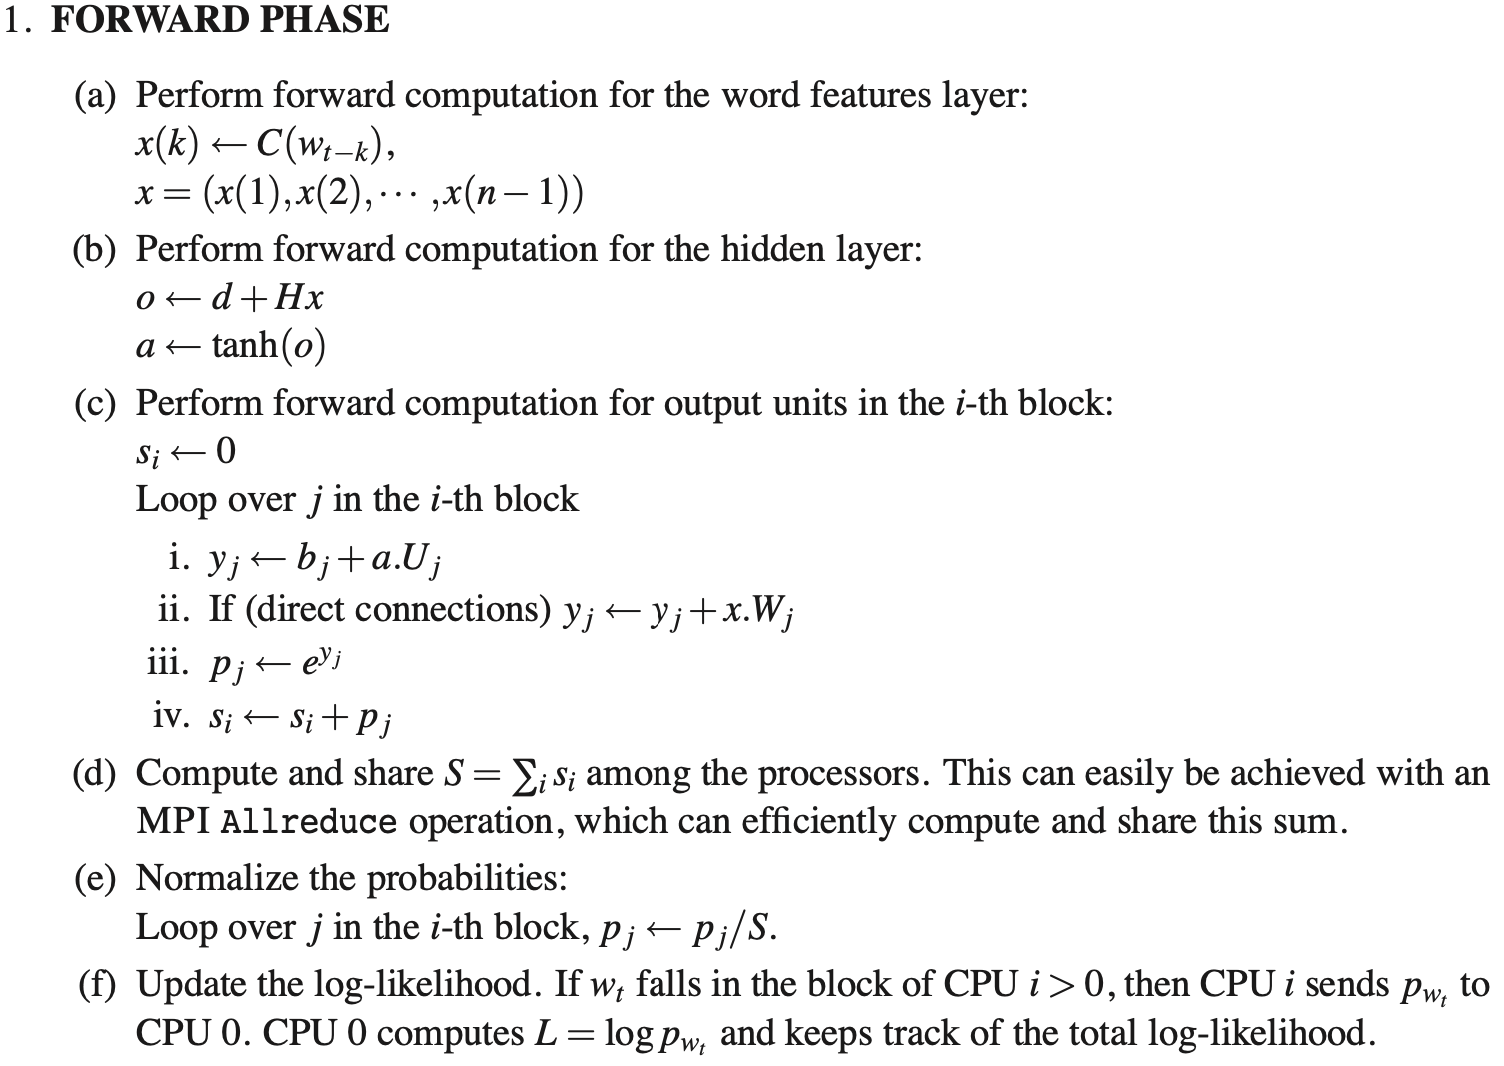

In [ ]:
Image('n3.png',width=600)

In [ ]:
# (a)
# (a)-1 원핫인코딩을 이용하여 word features vectors 만들기 

## 3.2 Backward phase

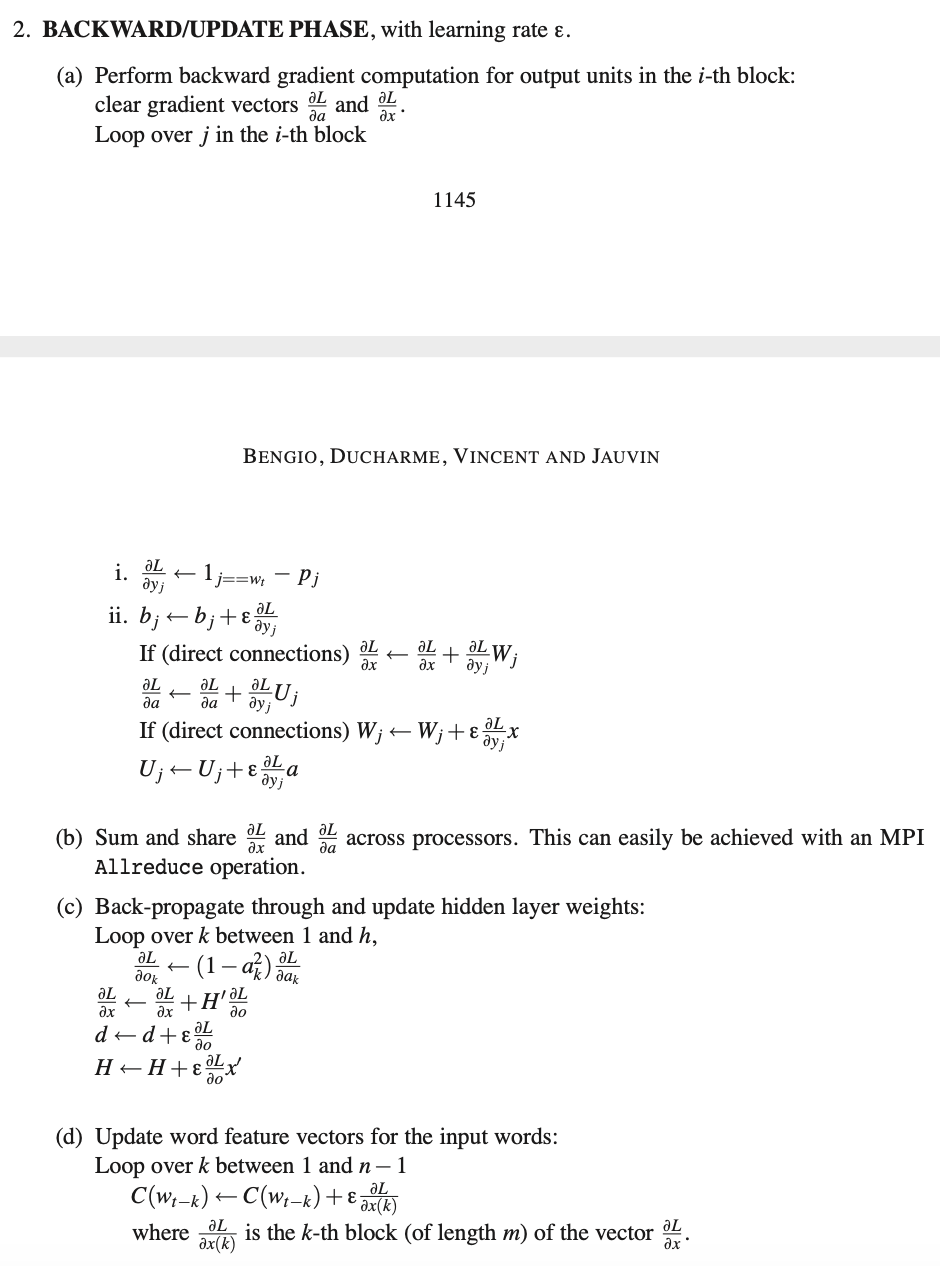

In [ ]:
Image('n4.png',width=600)

In [8]:
sentences = ["The engineering is based on the mathematics", "Many students dislike the mathematics", "But many students want to study the engineering"]

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = { w : i for i, w in enumerate(word_list)}
number_dict = { i : w for i, w in enumerate(word_list)}
n_class = len(word_dict)

print('(1) 단어들의 리스트: ','\n',word_list,'\n')
print('(2) 사전 형태로 표현된 단어 리스트: \n ', number_dict)
print('\n(3) 사전 형태의 단어 리스트 개수: \n', n_class)

n_step = 5
n_hidden = 5
m = 5

def make_batch(sentences):

    input_batch=[]
    target_batch=[]

    for sen in sentence:

        word = sen.split() # 각 단어의 index만을 리스트 형태로 출력
        input = [word_dict[n] for n in word[:-1]] # a 까지만 출력. 그 뒤에 무엇이 올지는 미정
        target = word_dict[word[-1]] # 맨 마지막 글자 (boy, girl, dog) 출력
        
        input_batch.append(input)
        target_batch.append(target)

    return input_batch, target_batch

(1) 단어들의 리스트:  
 ['on', 'the', 'based', 'Many', 'mathematics', 'students', 'to', 'engineering', 'dislike', 'The', 'But', 'many', 'study', 'is', 'want'] 

(2) 사전 형태로 표현된 단어 리스트: 
  {0: 'on', 1: 'the', 2: 'based', 3: 'Many', 4: 'mathematics', 5: 'students', 6: 'to', 7: 'engineering', 8: 'dislike', 9: 'The', 10: 'But', 11: 'many', 12: 'study', 13: 'is', 14: 'want'}

(3) 사전 형태의 단어 리스트 개수: 
 15


In [ ]:
sentences = ["The engineering is based on the mathematics", "Many students dislike the mathematics", "But many students want to study the engineering"]

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = { w : i for i, w in enumerate(word_list)}
number_dict = { i : w for i, w in enumerate(word_list)}
n_class = len(word_dict)

print('(1) 단어들의 리스트: ','\n',word_list,'\n')
print('(2) 사전 형태로 표현된 단어 리스트: \n ', number_dict)
print('\n(3) 사전 형태의 단어 리스트 개수: \n', n_class)

n_step = 5
n_hidden = 5
m = 5

def make_batch(sentences):

    input_batch=[]
    target_batch=[]

    for sen in sentences:

        word = sen.split() # 각 sentence를 word로 쪼개어 리스트 형태로 출력
        input = [word_dict[n] for n in word[:-1]] #  맨 마지막 word 제외한 나머지 출력. 그 뒤에 무엇이 올지는 미정
        target = word_dict[word[-1]] # 각 문장의 맨 마지막 글자만을 출력
    
        input_batch.append(input)
        target_batch.append(target)

    return input_batch, target_batch


class NPLM(object):

    def __init__(self):

        self.C = nn.Embedding(n_class, m)
        self.H = nn.Parameter(torch.randn(n_step * m, n_hidden).type(dtype))
        self.W = nn.Parameter(torch.randn(n_step * m, n_class).type(dtype))
        self.d = nn.Parameter(torch.randn(n_hidden).type(dtype))
        self.U = nn.Parameter(torch.randn(n_hidden, n_class).type(dtype))
        self.b = nn.Parameter(torch.randn(n_class).type(dtype))

(1) 단어들의 리스트:  
 ['the', 'dislike', 'on', 'engineering', 'The', 'students', 'mathematics', 'is', 'to', 'based', 'Many', 'But', 'want', 'study', 'many'] 

(2) 사전 형태로 표현된 단어 리스트: 
  {0: 'the', 1: 'dislike', 2: 'on', 3: 'engineering', 4: 'The', 5: 'students', 6: 'mathematics', 7: 'is', 8: 'to', 9: 'based', 10: 'Many', 11: 'But', 12: 'want', 13: 'study', 14: 'many'}

(3) 사전 형태의 단어 리스트 개수: 
 15


one_hot_encoding 벡터 이용하기
----
one_hot_encoded vector [B, V]
word_feature_matrix [V,E]

np.dot(one_hot_encoded vector, word_feature_matrix)

In [111]:
import numpy as np

sentences = ["The engineering is based on the mathematics", "Many students dislike the mathematics", "But many students want to study the engineering"]

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
n_words = len(word_list)

# (1) Output indices of the each word

  # (1-1) dict으로 구하기

char_to_integer = dict((i, c) for c, i in enumerate(word_list))
print('각 word의 index: ',char_to_integer) # check

  # (1-2) list를 이용하여 각 단어의 index 구하기

word_to_integer = list(i for i in range(n_words))
print('word to integer: ', word_to_integer)
    

# (2) Making onehot_vectors for the word_list

onehot_vector = list() # 초기화
onehot_vectors_set = list()

for i in word_to_integer: # 위에서 만든 word_to_integer를 하나씩 loop
    
    del onehot_vector[:] # word_to_integer의 loop를 돌 때마다 리스트 내의 데이터가 초기화
    
    for index in range(n_words): # 단어의 개수 만큼 돌면서, 증가하는 index가 word_to_integer loop에서 돌고 있는 Index와 동일할 때에만, 각각의 onehot_vector 리스트 내에 1을 추가, 그렇지 않으면 0 추가.
        
        if word_to_integer[i] == index:
        
            onehot_vector.append(1)

        else:
            onehot_vector.append(0)

    print(onehot_vector)
    onehot_vectors_set.append(onehot_vector) # 한번의 loop 마다 만들어지는 각각의 onehot_vector를 그것을 묶을 list 형태의 set에 추가
    
        
print('\n\n set: ', onehot_vectors_set)

# (3) Making "word_features_vectors"

#onehot_vectors_set = np.array(onehot_vectors_set) # matmul 연산을 위해 array화 해준다
#print(onehot_vectors_set)
#random_feature_matrix = np.random.rand()

    




각 word의 index:  {'on': 0, 'the': 1, 'based': 2, 'Many': 3, 'mathematics': 4, 'students': 5, 'to': 6, 'engineering': 7, 'dislike': 8, 'The': 9, 'But': 10, 'many': 11, 'study': 12, 'is': 13, 'want': 14}
word to integer:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


 set:  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Reference  
[1] Bengio, Yoshua, et al. "A neural probabilistic language model." Journal of machine learning research 3.Feb (2003): 1137-1155.  
[2] https://wikidocs.net/22647  
[3] https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/03/29/NNLM/  
[4] https://www.districtdatalabs.com/nlp-research-lab-part-1-distributed-representations 분산 표현이 무엇인지에 대한 흥미로운 사고 실험을 소개한다.  

[5] https://colab.research.google.com/github/graykode/nlp-tutorial/blob/master/1-1.NNLM/NNLM.ipynb